In [1]:
import pandas as pd
import random
from base64 import b64decode
from json import loads
import numpy as np
import matplotlib.pyplot as plt
# set matplotlib to display all plots inline with the notebook
%matplotlib inline

In [2]:
def parse(x):
    """
    to parse the digits file into tuples of 
    (labelled digit, numpy array of vector representation of digit)
    """
    digit = loads(x)
    array = np.fromstring(b64decode(digit["data"]),dtype=np.ubyte)
    array = array.astype(np.float64)
    return (digit["label"], array)

In [3]:
def parse(x):
    """
    Parse the digits file into tuples of 
    (labelled digit, numpy array of vector representation of digit)
    """
    digit = loads(x)
    array = np.frombuffer(b64decode(digit["data"]), dtype=np.ubyte)
    array = array.astype(np.float64)
    return (digit["label"], array)

In [8]:
file_path = "/Users/zahrafarook/Downloads/Benchmark _MNIST-K-Means-Clustering-master/digits.base64.json"
with open(file_path, "r") as f:
    digits = list(map(parse, f.readlines()))

# read in the digits file. Digits is a list of 60,000 tuples,
# each containing a labelled digit and its vector representation.
with open("/Users/zahrafarook/Downloads/Benchmark _MNIST-K-Means-Clustering-master/digits.base64.json","r") as f:
    digits = map(parse, f.readlines())

In [9]:
# pick a ratio for splitting the digits list into a training and a validation set.
#digits = list(digits)
ratio = int(len(digits)*0.25)
validation = digits[:ratio]
training = digits[ratio:]

In [10]:
def display_digit(digit, labeled=True, title=""):
    """ 
    Graphically displays a 784x1 vector, representing a digit.
    """
    if labeled:
        digit = digit[1]
    image = digit
    plt.figure()
    fig = plt.imshow(image.reshape(28, 28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if title:
        plt.title("Inferred label: " + str(title))
    plt.show()  # Ensure the plot is displayed
    plt.close()  # Close the figure to free memory


In [11]:
# writing Lloyd's Algorithm for K-Means clustering.
# (This exists in various libraries, but it's good practice to write by hand.)
def init_centroids(labelled_data, k):
    """
    Randomly pick some k centers from the data as starting values for centroids.
    Remove labels.
    """
    return list(map(lambda x: x[1], random.sample(labelled_data, k)))

# Define a function to sum a cluster element-wise
def sum_cluster(labelled_cluster):
    """
    Element-wise sums a list of arrays. Assumes all datapoints in labelled_cluster are labelled.
    """
    sum_ = labelled_cluster[0][1].copy()
    for (label, vector) in labelled_cluster[1:]:
        sum_ += vector
    return sum_

# Define a function to compute the mean of a cluster
def mean_cluster(labelled_cluster):
    """
    Computes the mean (i.e., the centroid at the middle) of a list of vectors (a cluster).
    Takes the sum and then divides by the size of the cluster.
    Assumes all datapoints in labelled_cluster are labelled.
    """
    sum_of_points = sum_cluster(labelled_cluster)
    mean_of_points = sum_of_points * (1.0 / len(labelled_cluster))
    return mean_of_points

In [12]:
# Define a function to form clusters
def form_clusters(labelled_data, unlabelled_centroids):
    """
    Given some data and centroids for the data, allocate each datapoint
    to its closest centroid. This forms clusters.
    """
    centroids_indices = range(len(unlabelled_centroids))
    clusters = {c: [] for c in centroids_indices}
    
    for (label, Xi) in labelled_data:
        smallest_distance = float("inf")
        for cj_index in centroids_indices:
            cj = unlabelled_centroids[cj_index]
            distance = np.linalg.norm(Xi - cj)
            if distance < smallest_distance:
                closest_centroid_index = cj_index
                smallest_distance = distance
        clusters[closest_centroid_index].append((label, Xi))
    
    return list(clusters.values())

# Define a function to move centroids
def move_centroids(labelled_clusters):
    """
    Returns a list of centroids corresponding to the clusters.
    """
    new_centroids = []
    for cluster in labelled_clusters:
        new_centroids.append(mean_cluster(cluster))
    return new_centroids

# Define a function to repeat until convergence
def repeat_until_convergence(labelled_data, labelled_clusters, unlabelled_centroids):
    """
    Form clusters around centroids, then keep moving the centroids
    until the moves are no longer significant, i.e., we've found
    the best-fitting centroids for the data.
    """
    previous_max_difference = 0
    while True:
        unlabelled_old_centroids = unlabelled_centroids
        unlabelled_centroids = move_centroids(labelled_clusters)
        labelled_clusters = form_clusters(labelled_data, unlabelled_centroids)
        
        differences = list(map(lambda a, b: np.linalg.norm(a - b), unlabelled_old_centroids, unlabelled_centroids))
        max_difference = max(differences)
        mean_difference = np.mean([previous_max_difference, max_difference])
        
        if mean_difference != 0:
            difference_change = abs((max_difference - previous_max_difference) / mean_difference) * 100
        else:
            difference_change = 0
        
        previous_max_difference = max_difference
        
        if np.isnan(difference_change) or difference_change == 0:
            break
    
    return labelled_clusters, unlabelled_centroids


In [13]:
def cluster(labelled_data, k):
    """
    runs k-means clustering on the data. It is assumed that the data is labelled.
    """
    centroids = init_centroids(labelled_data, k)
    clusters = form_clusters(labelled_data, centroids)
    final_clusters, final_centroids = repeat_until_convergence(labelled_data, clusters, centroids)
    return final_clusters, final_centroids

In [14]:
def assign_labels_to_centroids(clusters, centroids):
    """
    Assigns a digit label to each cluster.
    Cluster is a list of clusters containing labelled datapoints.
    NOTE: this function depends on clusters and centroids being in the same order.
    """
    labelled_centroids = []
    for i in range(len(clusters)):
        labels = list(map(lambda x: x[0], clusters[i]))  # Convert map to list
        # Pick the most common label
        most_common = max(set(labels), key=labels.count)
        centroid = (most_common, centroids[i])
        labelled_centroids.append(centroid)
    return labelled_centroids

In [15]:
def classify_digit(digit, labelled_centroids):
    """
    Given an unlabelled digit represented by a vector and a list of
    labelled centroids [(label, vector)], determine the closest centroid
    and thus classify the digit.
    """
    mindistance = float("inf")
    for (label, centroid) in labelled_centroids:
        distance = np.linalg.norm(centroid - digit)
        if distance < mindistance:
            mindistance = distance
            closest_centroid_label = label
    return closest_centroid_label

def get_error_rate(digits, labelled_centroids):
    """
    Classifies a list of labelled digits. Returns the error rate.
    """
    classified_incorrect = 0
    for (label, digit) in digits:
        classified_label = classify_digit(digit, labelled_centroids)
        if classified_label != label:
            classified_incorrect += 1
    error_rate = classified_incorrect / float(len(digits))
    return error_rate

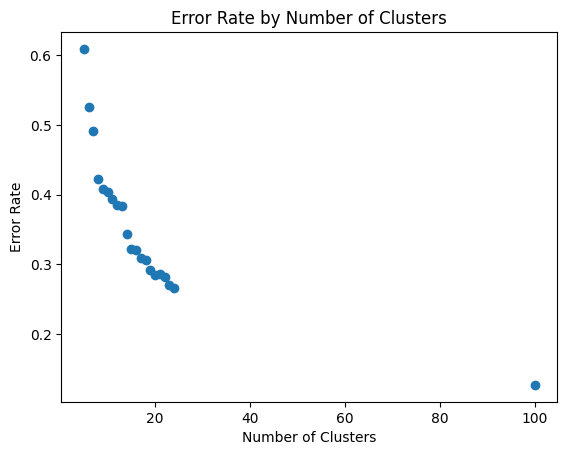

In [16]:
# Initialize error rates dictionary
error_rates = {x: None for x in list(range(5, 25)) + [100]}

# Calculate error rates for each value of k
for k in range(5, 25):
    trained_clusters, trained_centroids = cluster(training, k)
    labelled_centroids = assign_labels_to_centroids(trained_clusters, trained_centroids)
    error_rate = get_error_rate(validation, labelled_centroids)
    error_rates[k] = error_rate

# Also calculate for k=100
trained_clusters, trained_centroids = cluster(training, 100)
labelled_centroids = assign_labels_to_centroids(trained_clusters, trained_centroids)
error_rate = get_error_rate(validation, labelled_centroids)
error_rates[100] = error_rate

# Show the error rates
x_axis = sorted(error_rates.keys())
y_axis = [error_rates[key] for key in x_axis]
plt.figure()
plt.title("Error Rate by Number of Clusters")
plt.scatter(x_axis, y_axis)
plt.xlabel("Number of Clusters")
plt.ylabel("Error Rate")
plt.show()


In [ ]:
# Correcting the concatenation of range and list
error_rates = {x: None for x in list(range(5, 25)) + [100]}

for k in range(5, 25):
    trained_clusters, trained_centroids = cluster(training, k)
    labelled_centroids = assign_labels_to_centroids(trained_clusters, trained_centroids)
    error_rate = get_error_rate(validation, labelled_centroids)
    error_rates[k] = error_rate

# Also calculate for k=100
trained_clusters, trained_centroids = cluster(training, 100)
labelled_centroids = assign_labels_to_centroids(trained_clusters, trained_centroids)
error_rate = get_error_rate(validation, labelled_centroids)
error_rates[100] = error_rate

# Show the error rates
x_axis = sorted(error_rates.keys())
y_axis = [error_rates[key] for key in x_axis]
plt.figure()
plt.title("Error Rate by Number of Clusters")
plt.scatter(x_axis, y_axis)
plt.xlabel("Number of Clusters")
plt.ylabel("Error Rate")
plt.show()
